In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI
from tqdm import tqdm  # for timing loops

from graspologic.embed import CovariateAssistedEmbedding as CASE
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(42)


6it [00:26,  4.37s/it]
6it [00:30,  5.06s/it]
6it [00:30,  5.09s/it]
6it [00:31,  5.26s/it]


Text(0.5, 0, 'Covariate to graph block membership agreement')

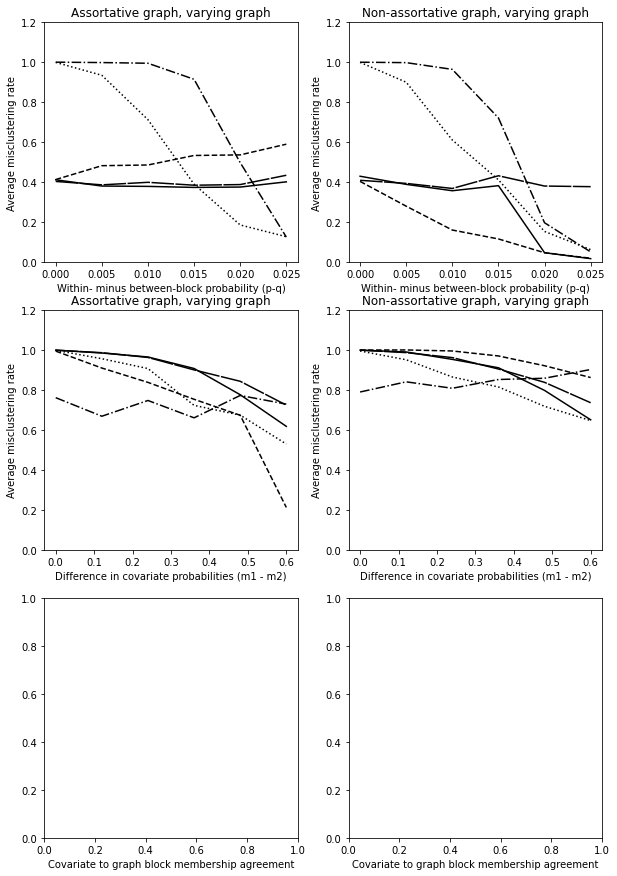

In [2]:


def gen_sbm(p, q, assortative=True, N=1500):
    if not assortative:
        p, q = q, p

    n = N//3
    A = np.full((3, 3), q)
    A[np.diag_indices_from(A)] = p
    return sbm([n, n, n], A, return_labels=True)


def gen_covariates(labels, m1, m2, d=3):
    """
    n x 3 matrix of covariates

    """
    n_total = len(labels)
    m2_array = np.random.choice([1, 0], p=[m2, 1-m2], size=(n_total, d))
    m1_array = np.random.choice([1, 0], p=[m1, 1-m1], size=n_total)
    m2_array[np.arange(n_total), labels] = m1_array
    return m2_array


def get_misclustering(A, model, labels, covariates=None):
    if covariates is None:
        Xhat = model.fit_transform(A)
    else:
        Xhat = model.fit_transform(A, covariates=covariates)

    kmeans = KMeans(n_clusters=3)
    labels_ = kmeans.fit_predict(Xhat)
    misclustering = 1 - ARI(labels, labels_)

    return misclustering


def trial(p=.03, q=.015, m1=.8, m2=.02, assort=True, algs=["assortative", "non_assortative", "CCA", "LSE", "COV"]) -> dict:
    """
    Return misclustering rates for all models under particular assumptions.

    """

    # set up models
    nc = 3
    assrttv_model = CASE(embedding_alg="assort",
                         n_components=nc, normalize=True)
    non_assrttv_model = CASE(embedding_alg="non-assort",
                             n_components=nc, normalize=True)
    cca_model = CASE(embedding_alg="cca", n_components=nc, normalize=True)
    reg_LSE_model = LSE(form="R-DAD", n_components=nc, normalize=True)
    cov_LSE_model = clone(reg_LSE_model)

    # collect models
    casc_models = {"assortative": assrttv_model,
                   "non_assortative": non_assrttv_model,
                   "CCA": cca_model,
                   "LSE": reg_LSE_model,
                   "COV": cov_LSE_model}

    # for testing purposes
    casc_models = {name: casc_models[name] for name in algs}

    # generate data
    A, labels = gen_sbm(p, q, assortative=assort, N=1500)
    X = gen_covariates(labels, m1, m2)

    # fit, cluster, get misclustering rates
    misclusterings = {}
    for name, model in casc_models.items():
        if name in {"assortative", "non_assortative", "CCA"}:
            misclustering = get_misclustering(A, model, labels, covariates=X)
        elif name == "LSE":
            misclustering = get_misclustering(A, model, labels)
        elif name == "COV":
            misclustering = get_misclustering(X@X.T, model, labels)

        misclusterings[name] = misclustering

    # return misclustering rates
    return misclusterings


def trials(p=.03, q=.015, m1=.8, m2=.02, trial_type="", assortative=True):
    """
    vary within-minus between-block probability (p-q)
    """
    num_trials = 6
    algorithms = ["assortative", "non_assortative", "CCA", "LSE", "COV"]
    # algorithms = ["LSE", "COV", "CCA"]

    # set trial parameters
    if trial_type == "probability":
        max_diff = .025
        x, y = p, q
    elif trial_type == "covariate":
        max_diff = .6
        x, y = m1, m2
    else:
        raise ValueError("need trial_type")

    # generate feature space
    xs = np.full(num_trials, y)
    diffs = np.linspace(0, max_diff, num=num_trials)
    ys = xs + diffs
    probs = np.c_[xs, ys]

    # trials
    results = np.zeros((num_trials, len(algorithms)+1))
    results[:, 0] = diffs
    for i, (x, y) in tqdm(enumerate(probs)):
        # for i, (p, q) in enumerate(probs):
        if trial_type == "probability":
            misclusterings = trial(
                p=x, q=y, assort=assortative, algs=algorithms)
        elif trial_type == "covariate":
            misclusterings = trial(
                m1=x, m2=y, assort=assortative, algs=algorithms)
        for j, name in enumerate(misclusterings.keys()):
            j += 1  # to account for the diffs column
            results[i, j] = misclusterings[name]

    columns = ["diffs"] + list(misclusterings.keys())
    results = pd.DataFrame(data=results, columns=columns)
    return results


def plot_results(results, ax=None, xlabel="", title=""):
    if ax is None:
        ax = plt.gca()

    linetypes = {"assortative": "k--", "non_assortative": "k-",
                 "CCA": "k:", "LSE": "k-."}

    X = results.loc[:, "diffs"].values
    results.drop("diffs", axis=1, inplace=True)
    for name in results.columns:
        if name == "COV":
            # custom linetype to get long dashes
            line, = ax.plot(X, results["COV"], 'k')
            line.set_dashes([15, 1])
        else:
            ax.plot(X, results[name], linetypes[name])

    ax.set(xlabel=xlabel, ylabel="Average misclustering rate",
           title=title, ylim=(0, 1.2))


# make figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
assortative_title = "Assortative graph, varying graph"
non_assortative_title = "Non-assortative graph, varying graph"

# plot probability trials
#  assortative
xlabel = "Within- minus between-block probability (p-q)"
assortative_prob = trials(trial_type="probability", assortative=True)
plot_results(assortative_prob,
             ax=axs[0, 0], xlabel=xlabel, title=assortative_title)

#  non-assortative
non_assortative_prob = trials(trial_type="probability", assortative=False)
plot_results(non_assortative_prob,
             ax=axs[0, 1], xlabel=xlabel, title=non_assortative_title)

# plot covariate trials
#  assortative
xlabel = "Difference in covariate probabilities (m1 - m2)"
assortative_cov = trials(trial_type="covariate", assortative=True)
plot_results(assortative_cov,
             ax=axs[1, 0], xlabel=xlabel, title=assortative_title)

#  non-assortative
non_assortative_cov = trials(trial_type="covariate", assortative=False)
plot_results(non_assortative_cov,
             ax=axs[1, 1], xlabel=xlabel, title=non_assortative_title)

# TODO
xlabel = "Covariate to graph block membership agreement"
axs[2, 0].set_xlabel(xlabel)
axs[2, 1].set_xlabel(xlabel)
